##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

C:\Users\wangs\Documents\GitFiles\Respondent_Recommendation\Model\.env\seq2seq\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:54: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.4.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
import pandas as pd
from bs4 import BeautifulSoup
import os
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
seed = 42

In [4]:
train_path = "../Data/StackExchange/Stackoverflow/cluster/train1/"
val_path = "../Data/StackExchange/Stackoverflow/cluster/val1/"
test_path = "../Data/StackExchange/Stackoverflow/cluster/test1/"

In [5]:
df_train = pd.read_csv("../Data/StackExchange/Stackoverflow/cluster/train1.csv")
df_val = pd.read_csv("../Data/StackExchange/Stackoverflow/cluster/val1.csv")
df_test = pd.read_csv("../Data/StackExchange/Stackoverflow/cluster/test1.csv")

In [6]:
class_num = sorted([str(folder) for folder in set(df_train["label"])])

In [7]:
len(class_num)

188

## Dataset Generation

In [8]:
def remove_non_ascii(sentence):
    return ''.join(char for char in sentence if ord(char) < 128)
    
def html_Filter(sentence):
    sentence = BeautifulSoup(sentence, "lxml").text
    #print("after html_Filter",sentence)
    
    return sentence

In [123]:
#create folders for training
for name in class_num:
    newpath = train_path+name+'/' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)

for i, sentence, label in zip(df_train["Id"], df_train["sentence"],df_train["label"]):
    sentence = html_Filter(sentence)
    sentence = remove_non_ascii(sentence)
    
    #vlabel_list.append(label)
    
    with open(train_path+str(label)+'/'+str(i)+".txt","w",encoding="UTF-8") as f:
        f.write(sentence)

In [ ]:
#create folders for validation
for name in class_num:
    newpath = val_path+name+'/' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)

for i, sentence, label in zip(df_val["Id"], df_val["sentence"],df_val["label"]):
    sentence = html_Filter(sentence)
    sentence = remove_non_ascii(sentence)
    
    #vlabel_list.append(label)
    
    with open(val_path+str(label)+'/'+str(i)+".txt","w",encoding="UTF-8") as f:
        f.write(sentence)

In [ ]:
#create folders for test
for name in class_num:
    newpath = test_path+name+'/' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)

for i, sentence, label in zip(df_test["Id"], df_test["sentence"],df_test["label"]):
    sentence = html_Filter(sentence)
    sentence = remove_non_ascii(sentence)
    
    #vlabel_list.append(label)
    
    with open(test_path+str(label)+'/'+str(i)+".txt","w",encoding="UTF-8") as f:
        f.write(sentence)

In [9]:
train_ds = tf.keras.utils.text_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode = 'categorical',
    batch_size=batch_size,
    shuffle = False,
    seed=seed)

#train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 9641 files belonging to 188 classes.


In [59]:

text_data = [text_batch.numpy() for text_batch, label_batch in train_ds.take(2)]


In [ ]:
text_data

In [10]:
val_ds = tf.keras.utils.text_dataset_from_directory(
    val_path,
    labels='inferred',
    label_mode = 'categorical',
    batch_size=batch_size,
    shuffle = False,
    seed=seed)

#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1072 files belonging to 188 classes.


In [11]:
test_ds = tf.keras.utils.text_dataset_from_directory(
    test_path,
    label_mode = 'categorical',
    shuffle = False,
    batch_size=batch_size)

#test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1191 files belonging to 188 classes.


### Tagset Generation

In [12]:
df = pd.read_csv("../Data/StackExchange/Stackoverflow/cluster.csv")

In [13]:
df.head()

,Id,sentence,tag,label
0,14182571,JSF - Null values from parameters - FacesConte...,<jsf><null><facescontext>,178864
1,14184182,Why won't Fragment retain state when screen is...,<android><android-fragments><android-preferenc...,34578
2,14187567,how to make an mail to form work <p>I know it ...,<php><html><css><email><forums>,5567
3,14198563,Swing JTable - Change background color of a ro...,<java><swing><swingx><jxtable>,308704
4,1359533,Dynamic compilation for performance <p>I have ...,<c#><performance><code-generation><dynamic-com...,130


In [14]:
len(df)

11904

In [15]:
tag_set = set()
all_tags = []


for tag_string in df["tag"]:

    tag_str = ""
    #retreive tag set
    tag_string = tag_string.replace("<","")
    tag_string = tag_string.replace(">"," ")
    tags = tag_string.strip().split(" ")
    
    all_tags.append(tags)
    tag_set.update(tags)


In [17]:
vocab_dict = {}
for i, tag in enumerate(sorted(list(tag_set))):
    vocab_dict[tag] = i 

In [18]:
#transform tag string into tf-idf vector
vectorizer = TfidfVectorizer(lowercase = False, vocabulary = vocab_dict)

In [19]:
tag_feature= vectorizer.fit_transform(df["tag"])
tag_feature.shape

(11904, 9041)

In [20]:
train_files = []
for train_folder in sorted(os.listdir(train_path)):
    file_path = train_path+train_folder+"/"
    train_files.extend(sorted(os.listdir(file_path)))

In [21]:
train_tags = []
for file in train_files:
    sid = file[:-4]
    tag_str = list(df_train[df_train["Id"] == int(sid)]["tag"].values)
    train_tags.extend(tag_str)

In [22]:
tag_train = vectorizer.fit_transform(train_tags)
tag_train.shape

(9641, 9041)

In [23]:
val_files = []
for val_folder in sorted(os.listdir(val_path)):
    file_path = val_path+val_folder+"/"
    val_files.extend(sorted(os.listdir(file_path)))

In [24]:
val_tags = []
for file in val_files:
    sid = file[:-4]
    tag_str = list(df_val[df_val["Id"] == int(sid)]["tag"].values)
    val_tags.extend(tag_str)

In [25]:
tag_val = vectorizer.fit_transform(val_tags)
tag_val.shape

(1072, 9041)

In [26]:
test_files = []
for test_folder in sorted(os.listdir(test_path)):
    file_path = test_path+test_folder+"/"
    test_files.extend(sorted(os.listdir(file_path)))

In [27]:
test_tags = []
for file in test_files:
    sid = file[:-4]
    tag_str = list(df_test[df_test["Id"] == int(sid)]["tag"].values)
    test_tags.extend(tag_str)

In [28]:
tag_test = vectorizer.fit_transform(test_tags)
tag_test.shape

(1191, 9041)

In [29]:
tag_train_ds = tf.data.Dataset.from_tensor_slices(tag_train.toarray())

In [30]:
tag_val_ds = tf.data.Dataset.from_tensor_slices(tag_val.toarray())

In [31]:
tag_test_ds = tf.data.Dataset.from_tensor_slices(tag_test.toarray())

## Restructure input

In [32]:
def tfdata_unzip(
    tfdata: tf.data.Dataset,
    *,
    recursive: bool=False,
    eager_numpy: bool=False,
    num_parallel_calls: int=tf.data.AUTOTUNE,
):
    """
    Unzip a zipped tf.data pipeline.

    Args:
        tfdata: the :py:class:`tf.data.Dataset`
            to unzip.

        recursive: Set to ``True`` to recursively unzip
            multiple layers of zipped pipelines.
            Defaults to ``False``.

        eager_numpy: Set this to ``True`` to return
            Python lists of primitive types or
            :py:class:`numpy.array` objects. Defaults
            to ``False``.

        num_parallel_calls: The level of parallelism to
            each time we ``map()`` over a
            :py:class:`tf.data.Dataset`.

    Returns:
        Returns a Python list of either
             :py:class:`tf.data.Dataset` or NumPy
             arrays.
    """
    if isinstance(tfdata.element_spec, tf.TensorSpec):
        if eager_numpy:
            return list(tfdata.as_numpy_iterator())
        return tfdata
        
    
    def tfdata_map(i: int) -> list:
        return tfdata.map(
            lambda *cols: cols[i],
            deterministic=True,
            num_parallel_calls=num_parallel_calls,
        )

    if isinstance(tfdata.element_spec, tuple):
        num_columns = len(tfdata.element_spec)
        if recursive:
            return [
                tfdata_unzip(
                    tfdata_map(i),
                    recursive=recursive,
                    eager_numpy=eager_numpy,
                    num_parallel_calls=num_parallel_calls,
                )
                for i in range(num_columns)
            ]
        else:
            return [
                tfdata_map(i)
                for i in range(num_columns)
            ]

    raise ValueError(
        "Unknown tf.data.Dataset element_spec: " +
        str(tfdata.element_spec)
    )

In [51]:
# use tfdata_unzip() to separate input from labels
input_train, input_labels = tfdata_unzip(train_ds)

# create a new input Dataset using .zip()
# data is structured as (1) a dictionary of inputs (input_images,in_vector) and (2) their associated labels (input_labels)
model_inputs = tf.data.Dataset.zip(({"sentences":input_train.unbatch(), "tags":tag_train_ds}, input_labels.unbatch()))

# if you then wanted to batch, cache, and/or prefetch the dataset you could do so using the following
model_inputs = model_inputs.shuffle(12000, reshuffle_each_iteration=False).batch(batch_size = batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [52]:
# use tfdata_unzip() to separate input from labels
input_val, input_val_labels = tfdata_unzip(val_ds)

# create a new input Dataset using .zip()
# data is structured as (1) a dictionary of inputs (input_images,in_vector) and (2) their associated labels (input_labels)
model_val = tf.data.Dataset.zip(({"sentences":input_val.unbatch(), "tags":tag_val_ds}, input_val_labels.unbatch()))


# if you then wanted to batch, cache, and/or prefetch the dataset you could do so using the following
model_val = model_val.shuffle(12000, reshuffle_each_iteration=False).batch(batch_size = batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [60]:
model_val

<PrefetchDataset element_spec=({'sentences': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'tags': TensorSpec(shape=(None, 9041), dtype=tf.float64, name=None)}, TensorSpec(shape=(None, 188), dtype=tf.float32, name=None))>

In [35]:
# use tfdata_unzip() to separate input from labels
input_test, input_test_labels = tfdata_unzip(test_ds)

# create a new input Dataset using .zip()
# data is structured as (1) a dictionary of inputs (input_images,in_vector) and (2) their associated labels (input_labels)
model_test = tf.data.Dataset.zip(({"sentences":input_test.unbatch(), "tags":tag_test_ds}, input_test_labels.unbatch()))


# if you then wanted to batch, cache, and/or prefetch the dataset you could do so using the following
model_test = model_test.shuffle(12000, reshuffle_each_iteration=False).batch(batch_size = batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [54]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'electra_small'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'electra_large':
        'https://tfhub.dev/google/electra_large/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'roberta_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'roberta_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/google/electra_small/2
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## Define custom model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [55]:
def build_combined_model(feature_size, class_num=1):
    input1 = tf.keras.layers.Input(shape=(), dtype=tf.string, name='sentences')
    input2 = tf.keras.layers.Input(shape=(feature_size,), dtype=tf.float32, name='tags')
    
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(input1)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2)(net)
    
    net = tf.concat([net, input2], 1)
    net = tf.keras.layers.Dense(class_num, activation='softmax', name='classifier')(net)
    return tf.keras.Model([input1,input2], net)
    #return tf.keras.Model(input1, net)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [56]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.metrics.CategoricalAccuracy('balanced_accuracy')

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [57]:
epochs = 15
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=0,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [58]:
classifier_model = build_combined_model(tag_feature.shape[1], class_num = len(class_num))
#classifier_model = build_combined_model(1, class_num = len(class_num))
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [59]:
classifier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sentences (InputLayer)         [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['sentences[0][0]']              
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [60]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=model_inputs,
                               validation_data=model_val,
                               epochs=epochs)

Training model with https://tfhub.dev/google/electra_small/2
Epoch 1/15
603/603 [==============================] - 84s 115ms/step - loss: 4.8544 - balanced_accuracy: 0.1191 - val_loss: 4.5877 - val_balanced_accuracy: 0.1427
Epoch 2/15
603/603 [==============================] - 68s 113ms/step - loss: 4.4327 - balanced_accuracy: 0.1612 - val_loss: 4.2640 - val_balanced_accuracy: 0.1800
Epoch 3/15
603/603 [==============================] - 70s 115ms/step - loss: 4.1511 - balanced_accuracy: 0.1932 - val_loss: 4.0426 - val_balanced_accuracy: 0.2015
Epoch 4/15
603/603 [==============================] - 70s 116ms/step - loss: 3.9023 - balanced_accuracy: 0.2217 - val_loss: 3.8598 - val_balanced_accuracy: 0.2267
Epoch 5/15
603/603 [==============================] - 69s 114ms/step - loss: 3.6850 - balanced_accuracy: 0.2485 - val_loss: 3.7041 - val_balanced_accuracy: 0.2509
Epoch 6/15
603/603 [==============================] - 69s 114ms/step - loss: 3.5007 - balanced_accuracy: 0.2786 - val_loss: 

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [61]:
loss, accuracy = classifier_model.evaluate(model_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

75/75 [==============================] - 4s 57ms/step - loss: 3.2123 - balanced_accuracy: 0.3123
Loss: 3.2122561931610107
Accuracy: 0.3123425841331482


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'balanced_accuracy', 'val_loss', 'val_balanced_accuracy'])


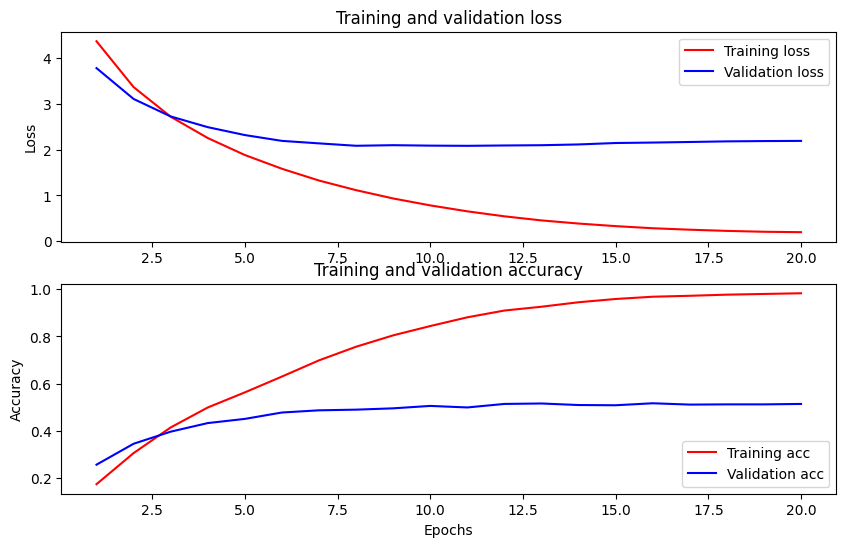

In [75]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['balanced_accuracy']
val_acc = history_dict['val_balanced_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [62]:
dataset_name = 'relatedpost1'
saved_model_path = 'sen_bert_m_models/{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

Let's reload the model, so you can try it side by side with the model that is still in memory.

In [63]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [165]:
def print_my_examples(inputs, results):
    result_for_printing = \
        [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}' for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()

    examples = [
        "Lines intersections For two lines or two paths or two point lists as shapes in WPF and c#, does anyone have an idea how to detect the intersection and draw the intersection in a rounded shape to make it clear to the eye that these two lines are not connected (MS visio like)? I just need the principle of doing this, although some code will be helpful. thanks."# this is the same sentence tried earlier
    ]
    
    tag_list = [
        "",
    ]
    
    model_evalute = tf.data.Dataset.zip(({"sentences":input_train.unbatch(), "tags":tag_train_ds}, input_labels.unbatch()))
    reloaded_results = tf.nn.softmax(reloaded_model(tf.constant(examples)))
    #original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

    print('Results from the saved model:')
    print_my_examples(examples, reloaded_results)
    #print('Results from the model in memory:')
    #print_my_examples(examples, original_results)

Results from the saved model:
input: Lines intersections For two lines or two paths or two point lists as shapes in WPF and c#, does anyone have an idea how to detect the intersection and draw the intersection in a rounded shape to make it clear to the eye that these two lines are not connected (MS visio like)? I just need the principle of doing this, although some code will be helpful. thanks. : score: 0.005293



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [166]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.nn.softmax(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: Lines intersections For two lines or two paths or two point lists as shapes in WPF and c#, does anyone have an idea how to detect the intersection and draw the intersection in a rounded shape to make it clear to the eye that these two lines are not connected (MS visio like)? I just need the principle of doing this, although some code will be helpful. thanks. : score: 0.005293



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.